# Projeto Final da Disciplina Modelos Descritivos Ministrada pelo Prof. Pedro Braga

**Equipe:**
<br>David Soares do Monte
<br>Wanderson Rodrigues Marques

<h1 align=center>Geração de Imagens Sintéticas com DCGANs no Keras - Parte 1</h1>
<h4 align=center>DCGAN - Deep Convolutional Generative Adversarial Network</h4>

## Objetivo

O objetivo principal do projeto é treinar um gerador de imagens sintéticas que consiga gerar novas imagens para cada uma das classes do dataset *Fashion*-MNIST. Além disso, pretende-se realizar modificações no script utilizado no dataset *Fashion*-MNIST para ser utilizado no dataset CIFAR10 que contém imagens coloridas. A **Parte 1** deste trabalho está focada no dataset *Fashion*-MNIST, enquanto a **Parte 2** está direcionada para o dataset CIFAR10.

## Metodologia - Parte 1
O projeto desenvolvido consistiu na implementação de um Gerador de Imagens Sintéticas por meio de uma *Deep Convolutional Generative Adversarial Network* (DCGAN) usando a biblioteca de rede neural Keras.
<br>
O dataset utilizado na **Parte 1** deste projeto foi o *Fashion*-MNIST que possui 70.000 imagens de moda. O *Fashion*-MNIST é um conjunto de dados das imagens do artigo de Zalando — que consiste em um conjunto de treinamento de 60.000 exemplos e um conjunto de testes de 10.000 exemplos. Cada exemplo é uma imagem em escala de tons de cinza, possuindo dimensão de 28×28, associada a um rótulo de 10 classes.
<br>
Cada exemplo de treinamento e teste é atribuído a um dos seguintes rótulos:

* 0 - Camiseta
* 1 - Calça
* 2 - Pullover
* 3 - Vestido
* 4 - Casaco
* 5 - Sandália
* 6 - Camisa
* 7 - Tênis
* 8 - Bolsa
* 9 - Bota

Para mais informações sobre o *Fashion*-MINIST acesse: https://github.com/zalandoresearch/fashion-mnist

## Breve Introdução sobre as GANs
As GANs são utilizadas para aprendizado não-supervisionado e consistem na combinação de dois componentes: o gerador, cuja função é gerar novas instâncias; e o discriminador, cuja função é avaliar a autenticidade das instâncias. Nas GANs, duas redes treinam uma contra a outra. O gerador tenta enganar o discriminador criando entradas falsas convincentes, enquanto o discriminador informa se uma entrada é real ou artificial. Existem vários tipos de GANs, dentre elas: CGAN (Condicional GAN), DCGAN (Deep Convolutional GAN), LAPGAN (Laplacian Pyramid GAN) e SRGAN (Super Resolution GAN). 

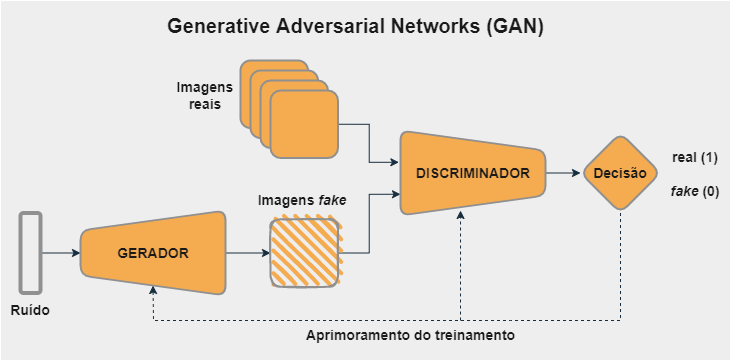

O treinamento de uma GAN consiste em três etapas principais:
1. Use o gerador para criar entradas (imagens) *fakes* baseadas no ruído;
2. Treine o discriminador com ambas entradas: real e *fake*;
3. Treine o modelo completo que é composto pelo discriminador e pelo gerador.

Durante a etapa 3 o treinamento do discriminador é desabilitado e, portanto, seus pesos não serão modificados nesta etapa.

As aplicações das GANs incluem:
* Geração de imagens sintéticas para conjuntos de dados de imagem;
* Geração de fotografias de rostos humanos;
* Geração de fotografias realistas;
* Geração de personagens de desenhos animados;
* Tradução de imagem para imagem;
* Tradução de texto para imagem;
* Tradução semântica de imagem para foto.

# Pipeline do Projeto

Pipeline adotado neste projeto para a geração de imagens sintéticas utilizando uma DCGAN:
1. Importa Bibliotecas;
2. Carrega o *dataset* e pré-processa os dados;
3. Cria os *batches* dos dados de treinamento;
4. Implementa o Gerador;
5. Implementa o discriminador;
6. Compila o DCGAN;
7. Define o procedimento de treinamento;
8. Implementa função para exibir e salvar as imagens geradas em cada época;
9. Treino do DCGAN;
10. Gera imagens sintéticas.

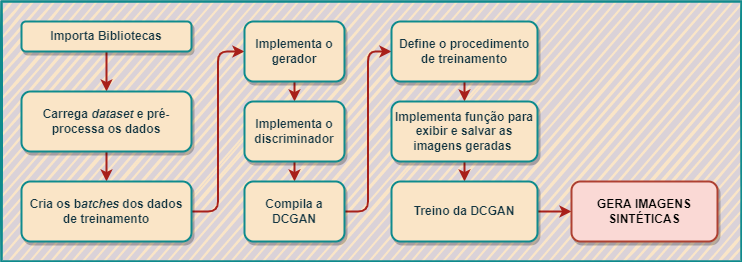

# Implementação do Projeto

## 1.Importação das Bibliotecas



In [16]:
#!pip install git+https://github.com/tensorflow/docs

In [17]:
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout #, LSTM, Conv1D, Embedding, Input
import tensorflow_docs.vis.embed as embed
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython import display
import imageio
import glob

print('Tensorflow version:', tf.__version__)

Tensorflow version: 2.6.0


### 1.1.Função Auxiliar para Exibição das Imagens

In [18]:
def plot_utils_show(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="gray_r")
        plt.axis("off")

## 2.Carrega o Dataset e Pré-processa os Dados;

In [19]:
# Carrega os dados de treino e teste
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

In [20]:
# Classes contidas no dataset
n_classes = len(np.unique(y_train))
classes = np.unique(y_train)
classes_names = {0:'Camiseta', 1:'Calça', 2:'Pullover', 3:'Vestido', 4:'Casaco', 5:'Sandália', 6:'Camisa', 7:'Tênis', 8:'Bolsa', 9:'Bota'}

In [21]:
# Imprime o tamanho dos datasets de treino e teste, bem como o tamanho de cada imagem e o número de classes
print('Tamanho do conjunto de treino: ', X_train.shape)
print('Tamanho do conjunto de teste: ', X_test.shape)
print('Dimensão das imagens: ', X_train[0].shape)
print('Quantidade total de classes: ', n_classes)
print('Rótulos das classes: ', classes)
print('Nomes das classes: ', [*classes_names.values()])

Tamanho do conjunto de treino:  (60000, 28, 28)
Tamanho do conjunto de teste:  (10000, 28, 28)
Dimensão das imagens:  (28, 28)
Quantidade total de classes:  10
Rótulos das classes:  [0 1 2 3 4 5 6 7 8 9]
Nomes das classes:  ['Camiseta', 'Calça', 'Pullover', 'Vestido', 'Casaco', 'Sandália', 'Camisa', 'Tênis', 'Bolsa', 'Bota']


In [22]:
# Verifica o maior e menor valor de cada pixel no dataset
print('Máximo valor de um pixel no dataset de treino: ', np.max(X_train))
print('Mínimo valor de um pixel no dataset de treino: ', np.min(X_train))

Máximo valor de um pixel no dataset de treino:  255
Mínimo valor de um pixel no dataset de treino:  0


In [23]:
# Faz a normalização dos atributos de treino (X_train) e teste (X_test) e ajusta o tipo para 'np.float32'
# O ajuste de tipo faz-se necessário porque os pesos serão do tipo float e multiplicação entre números do mesmo tipo é mais rápida.
X_train = X_train.astype(np.float32) / np.max(X_train)
X_test = X_test.astype(np.float32) / np.max(X_test)

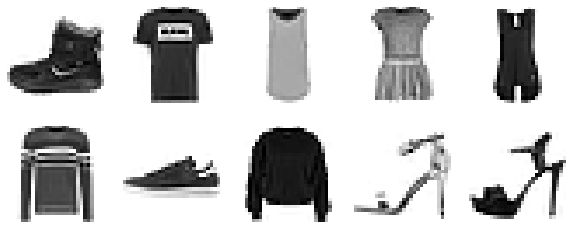

In [24]:
# Exibe uma amostra de 10 imagens oriundas do conjunto de treino (X_train)
plt.figure(figsize=(10,4))

for i in range(10):
    plt.subplot(2,5,i+1)  # 2 linhas e 5 colunas
    plt.axis('off')       # Desabilita os eixos nas plotagens das imagens
    plt.imshow(X_train[i], cmap='gray_r') # Escala em tons de cinza
plt.show()

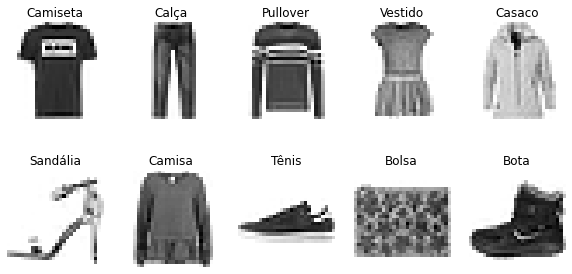

In [25]:
# Imprimindo uma imagem de cada classe
fig=plt.figure(figsize=(10, 5))

for i in range(n_classes):
  plt.subplot(2, 5, i+1)             # 2 linhas e 5 colunas
  plt.title(str(classes_names[i]))   # Rótulos (labels)
  plt.axis('off')                    # Desabilita os eixos nas plotagens das imagens
  plt.imshow(X_train[np.where(y_train==i)][0], cmap='gray_r') # Escala em tons de cinza
plt.show()

## 3.Cria os *Batches* dos Dados de Treinamento

In [26]:
batch_size = 32    # Tamanho do batch de treinamento
buffer_size = 1000 # Número de elementos dos quais o novo conjunto de dados será amostrado

dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(buffer_size)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

## 4.Implementa o Gerador para o DCGAN

In [27]:
num_features = 100

generator = Sequential([
    keras.layers.Dense(7 * 7 * 256, input_shape=[num_features]),
    keras.layers.Reshape([7, 7, 256]),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(128, (5,5), (1,1), padding="same", activation="selu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(64, (5,5), (2,2), padding="same", activation="selu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(1, (5,5), (2,2), padding="same", activation="tanh"),
])

generator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 12544)             1266944   
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 256)         0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 7, 7, 256)         1024      
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 7, 7, 128)         819328    
_________________________________________________________________
batch_normalization_4 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 14, 14, 64)        204864    
_________________________________________________________________
batch_normalization_5 (Batch (None, 14, 14, 64)       

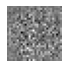

In [28]:
noise = tf.random.normal(shape=[1, num_features])
generated_images = generator(noise, training=False)
plot_utils_show(generated_images, 1)

## 5.Implementa o Discriminador para o DCGAN

In [29]:
input_shape_img = [28,28,1] # Formato de entrada das imagens

discriminator = keras.models.Sequential([
    keras.layers.Conv2D(64, (5,5), (2,2), padding="same", input_shape=input_shape_img),
    keras.layers.LeakyReLU(0.2), # Função de ativação
    keras.layers.Dropout(0.3),   # Regularizador
    keras.layers.Conv2D(128, (5,5), (2,2), padding="same"),
    keras.layers.LeakyReLU(0.2),
    keras.layers.Dropout(0.3),
    keras.layers.Conv2D(256, (5,5), (1,1), padding="same"),
    keras.layers.LeakyReLU(0.2),
    keras.layers.Dropout(0.3),
    keras.layers.Flatten(),
    keras.layers.Dense(1, activation='sigmoid')
])
# Obs.: A última camada utiliza função de ativação sigmoid por se tratar de uma 
# classificação binária: a imagem é real ou fake

discriminator.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 256)        

In [30]:
decision = discriminator(generated_images)
print(decision)

tf.Tensor([[0.49986914]], shape=(1, 1), dtype=float32)


## 6.Compila a DCGAN

In [31]:
# Compila o discriminador utilizando como função de perda a 'binary_crossentropy' e o otimizador 'rmsprop'

discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop") 
discriminator.trainable = False  # Configurando o discriminador como não treinável antes da compilação do GAN

# Composição do GAN
gan = keras.models.Sequential([generator, discriminator])

# Compila o gan utilizando como função de perda a 'binary_crossentropy' e o otimizador 'rmsprop'
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

gan.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 28, 28, 1)         2294529   
_________________________________________________________________
sequential_2 (Sequential)    (None, 1)                 1038593   
Total params: 3,333,122
Trainable params: 2,293,633
Non-trainable params: 1,039,489
_________________________________________________________________


## 7.Define o Procedimento de Treinamento da DCGAN

### 7.1.Sequência de Treinamento

In [32]:
def train_dcgan(gan, dataset, batch_size, num_features, epochs=5):
    generator, discriminator = gan.layers  # Carrega gerador e discriminador

    discriminator_losses = []
    generator_losses = []

    for epoch in tqdm(range(epochs), desc='Progress'): # Barra de progresso para cada época
        print("Epoch {}/{}".format(epoch + 1, epochs)) # Exibição das épocas
        
        for X_real_batch in dataset:                   # Para cada batch de imagens no dataset:
            noise = tf.random.normal(shape=[batch_size, num_features])
            generated_images = generator(noise)        # Imagens ruidosas (fake) obtidas com o gerador

            X_fake_and_real = tf.concat([generated_images, X_real_batch], axis=0) # Concatena imagens geradas (fake) e originais
            dis_labels = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)   # Definindo as labels: 
                                                                                  # img. fakes (0) e img. originais (1)
            discriminator.trainable = True                                        # Habilita o treino do discriminador
            dis_loss = discriminator.train_on_batch(X_fake_and_real, dis_labels)  # Fornece o conjunto de imagens (fakes + originais) e suas labels 
            discriminator_losses.append(dis_loss)                                 # para classificação pelo discriminador

            noise = tf.random.normal(shape=[batch_size, num_features]) # Cria um batch de imagens fake 
            dcgan_labels = tf.constant([[1.]] * batch_size)            # Rotular as imagens fake como originais (1)
            
            discriminator.trainable = False                      # Desabilita o treino do discriminador
            gan_loss = gan.train_on_batch(noise, dcgan_labels)   # Alimenta o DCGAN com um batch de imagens fake rotuladas como originais (1) para classificação
            generator_losses.append(gan_loss)

            # Gerando uma imagem ao final de cada época
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, seed)
        print("\nDiscriminator Loss: ", dis_loss, ", GAN Loss: ", gan_loss)
    
    #Plotando as perdas durante o treinamento
    plt.figure()
    plt.plot(range(len(discriminator_losses)), discriminator_losses,color='red', label='Discriminator loss')
    plt.plot(range(len(generator_losses)), generator_losses, color='blue', label='GAN loss')
    plt.title('Discriminator and GAN loss')
    plt.xlabel('Iterations')
    plt.ylabel('Loss (GAN/Discriminator)')
    plt.legend()
    plt.show()

### 7.2.Implementa Função para Exibir e Salvar as Imagens Geradas a cada Época

In [33]:
## Fonte do código: https://www.tensorflow.org/tutorials/generative/dcgan#create_a_gif

# Esta seed será utilizada para visualizar o progresso do GIF animado
# O gerador irá produzir imagens a partir desta seed (ruído randômico)

n_examples_to_generate = 25    # Quantidade de exemplos que serão exibidos
seed = tf.random.normal(shape=[n_examples_to_generate, num_features])

def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(10,10))

  for i in range(n_examples_to_generate):
      plt.subplot(5, 5, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray_r')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

## 8.Treino da DCGAN

In [34]:
# Redimensiona o conjunto de treino e faz um reescalonamento para [-1,1]
X_train_dcgan = X_train.reshape(-1, 28, 28, 1) * 2. - 1.
X_train_dcgan.shape

(60000, 28, 28, 1)

In [35]:
#batch_size = 32   # Tamanho do lote (batch)
dataset = tf.data.Dataset.from_tensor_slices(X_train_dcgan)
dataset = dataset.shuffle(buffer_size)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

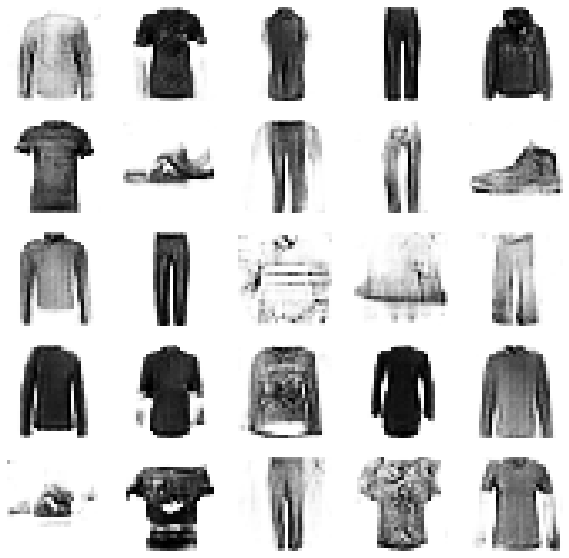

Progress: 100%|████████████████████████████████████████████████████████████████████████| 10/10 [12:18<00:00, 73.84s/it]


Discriminator Loss:  0.5041407346725464 , GAN Loss:  1.1558761596679688


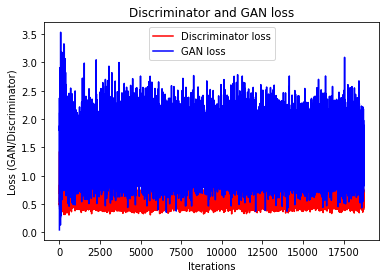

CPU times: total: 14min 37s
Wall time: 12min 18s


In [36]:
%%time
# Define o número de épocas e treina a DCGAN
n_epochs = 10  # Número de épocas
train_dcgan(gan, dataset, batch_size, num_features, epochs=n_epochs)

### 8.1.Gif com as Imagens Geradas em cada Época


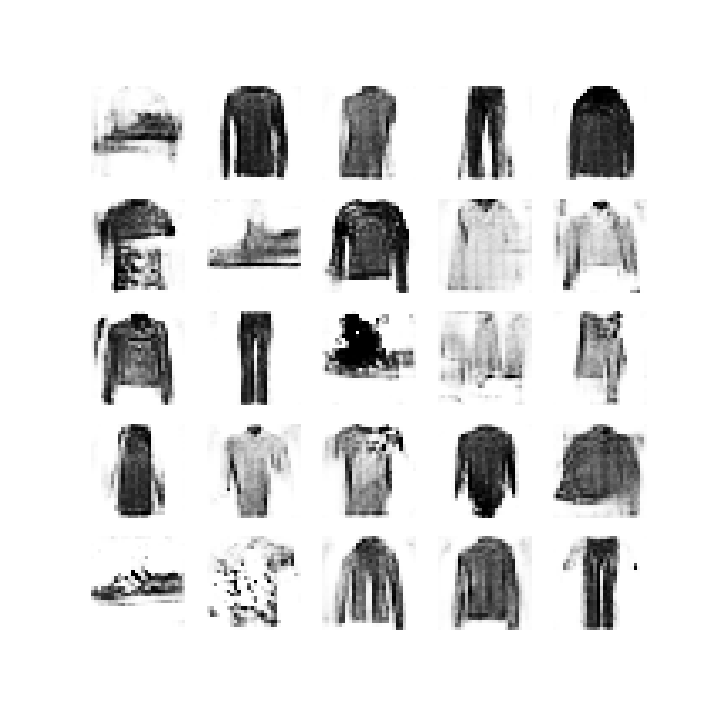

In [37]:
## Adaptado de: https://www.tensorflow.org/tutorials/generative/dcgan#create_a_gif

anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

embed.embed_file(anim_file)

## 9.Gera Imagens Sintéticas com a DCGAN

IMAGENS SINTÉTICAS:


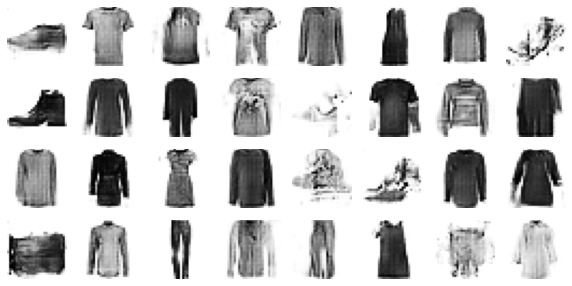


IMAGENS ORIGINAIS:


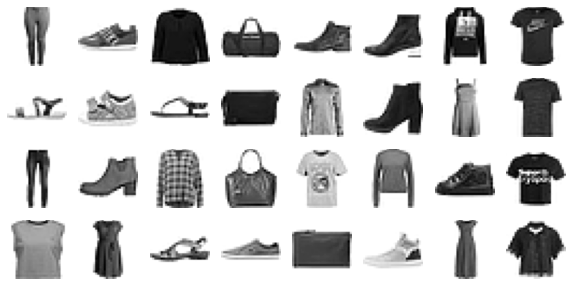

In [38]:
# Gera imagens sintéticas
noise = tf.random.normal(shape=[batch_size, num_features], seed=1275)
generated_images = generator.predict(noise)

# Exibe as imagens geradas
print('IMAGENS SINTÉTICAS:')

fig=plt.figure(figsize=(10, 5))

for i in range(noise.shape[0]):
  plt.subplot(4, 8, i+1)  # 4 linhas e 8 colunas
  plt.axis('off')         # Desabilita os eixos nas plotagens das imagens
  image = generated_images[i]

  if image.shape[-1] == 1:
      image = np.squeeze(image, axis=-1)
  plt.imshow(image, cmap='gray_r') # Escala em tons de cinza
plt.show()

# Exibe imagens originais
print('\nIMAGENS ORIGINAIS:')

plt.figure(figsize=(10,5))
j = 0
for i in np.random.randint(low=0, high=len(X_test)-1, size=noise.shape[0]):
    j = j + 1
    plt.subplot(4,8,j)    # 4 linhas e 8 colunas
    plt.axis('off')       # Desabilita os eixos nas plotagens das imagens
    plt.imshow(X_test[i], cmap='gray_r') # Escala em tons de cinza
plt.show()

Como o objetivo do trabalho é gerar imagens sintéticas, após o treinamento da DCGAN descarta-se o discriminador e foca-se no gerador. Quando alimenta-se o gerador com ruído randômico, observa-se que as imagens produzidas são satisfatórias e coerentes. Uma simples comparação com um conjunto de imagens originais de mesma dimensão ratifica o êxito dos resultados alcançados.

# Conclusões da Parte 1

O objetivo deste projeto era gerar imagens sintéticas para o *dataset* *Fashion*-MNIST utilizando uma DCGAN. Tal objetivo foi alcançado e os resultados foram satisfatórios, como ficou demonstrado na subseção 9 da implentação do projeto. Foram geradas com êxito, 32 imagens sintéticas distintas por meio do gerador treinado que faz parte da DCGAN.
<br>O desenvolvimento e consolidação de cada etapa deste projeto foi de crucial importância para o entendimento do funcionamento de uma DCGAN. Desde a análise do *dataset*, passando pela implementação do gerador e do discriminador que compõem uma DCGAN, até o treinamento do modelo e consequente geração de imagens sintéticas.
<BR>Uma possível extensão da metodologia adotada neste notebook será a utilização de um *dataset* contendo imagens RGB (coloridas). Essa iniciativa irá requerer ajustes nas camadas convolucionais, bem como ajustes ao longo do *script* para lidar com tais imagens. Tal extensão foi desenvolvida na **Parte 2** deste projeto (arquivo **Parte_2_DCGAN_color_full.ipynb**).